In [94]:
import json
from datetime import datetime
import plotly.express as px
from sklearn.model_selection import train_test_split
import sqlite3
import nltk
import spacy
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import umap
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
%matplotlib inline

In [95]:
df_business_last_4yrs = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/capstone4_files/df_business_last_4yrs_open.csv')


In [96]:
df_reviews_4yrs = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/capstone4_files/df_reviews_last_4yrs_open.csv')



/Users/robholmstrom/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [97]:
df_reviews_4yrs['stars'] = df_reviews_4yrs['stars'].values.tolist() # = df_reviews_4yrs['stars'].astype(int)

In [98]:
df_reviews_4yrs['stars'].value_counts()

5.0    2229116
1.0     790052
4.0     749358
3.0     380970
2.0     315129
Name: stars, dtype: int64

In [99]:
df_reviews_4yrs_mean = pd.DataFrame(df_reviews_4yrs.groupby('business_id')['stars'].mean())

In [100]:
df_business_last_4yrs['is_open'].value_counts()

1    163300
Name: is_open, dtype: int64

In [101]:
df_business_rev = df_business_last_4yrs.merge(df_reviews_4yrs_mean, on='business_id').drop('stars_x', axis=1)
df_business_rev['stars_avg'] = df_business_rev['stars_y'].round(0).astype(int)


In [102]:
df_business_last_4yrs = df_business_last_4yrs.loc[df_business_last_4yrs['is_open']==1]

In [103]:
df_business_rev_v2 = df_business_rev.drop(['attributes', 'stars_y','hours'], axis= 1)

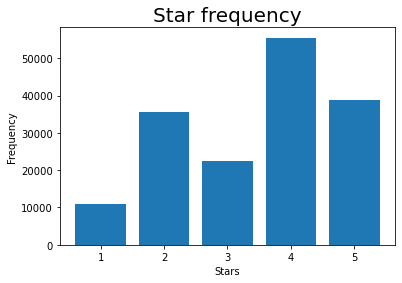

In [104]:
plt.bar(df_business_rev_v2['stars_avg'].unique(), height = df_business_rev_v2['stars_avg'].value_counts())
plt.ylabel('Frequency', fontsize = 10)  
plt.xlabel('Stars', fontsize = 10)  
plt.title(label = 'Star frequency', fontsize=20)
plt.show()

In [105]:
df_bus_rev_select =  df_business_rev_v2[df_business_rev_v2['review_count']>10]
df_bus_rev_select.shape

(79596, 13)

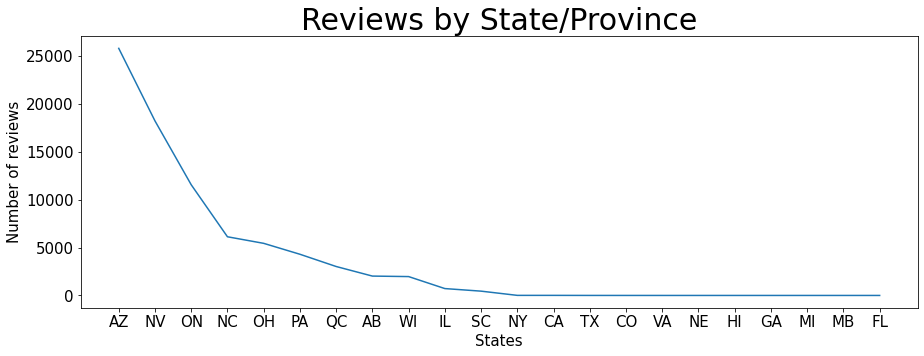

In [106]:
plt.figure(figsize = (15, 5))
plt.plot(df_bus_rev_select['state'].value_counts())
plt.xlabel('States', fontsize = 15)  
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('Number of reviews', fontsize = 15)  
plt.title(label = 'Reviews by State/Province', fontsize=30)
plt.show()

In [107]:
threshold = 0.1
review_by_state = pd.DataFrame(df_bus_rev_select['state'].value_counts())
states_select = review_by_state[review_by_state['state'] > threshold*review_by_state.max()['state']]
states_select

,state
AZ,25777
NV,18208
ON,11548
NC,6122
OH,5436
PA,4298
QC,3020


In [108]:
df_bus_rev_select = df_bus_rev_select.loc[df_bus_rev_select['state'].isin(states_select.index)==True]

In [109]:
df_bus_rev_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74409 entries, 0 to 163297
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    74409 non-null  int64  
 1   business_id   74409 non-null  object 
 2   name          74409 non-null  object 
 3   address       72279 non-null  object 
 4   city          74409 non-null  object 
 5   state         74409 non-null  object 
 6   postal_code   74334 non-null  object 
 7   latitude      74409 non-null  float64
 8   longitude     74409 non-null  float64
 9   review_count  74409 non-null  int64  
 10  is_open       74409 non-null  int64  
 11  categories    74399 non-null  object 
 12  stars_avg     74409 non-null  int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 7.9+ MB


In [110]:
df_food_bus = df_bus_rev_select[df_bus_rev_select['categories'].str.contains('Restaurant')|
                 df_bus_rev_select['categories'].str.contains('Coffee & Tea')]

In [111]:
df_food = df_food_bus.copy()
catlist_clean = df_food['categories'].str.replace(' ', '' ).str.replace(',', ', ')

In [112]:
df_food['categories_filtered']= catlist_clean

In [113]:
food_categories = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/Yelp_food_categories.csv')
food_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Categories   0 non-null      float64
 1   Food_types   69 non-null     object 
 2   Ethnicities  96 non-null     object 
 3   Venue_type   51 non-null     object 
dtypes: float64(1), object(3)
memory usage: 6.9+ KB


In [114]:
food_types = food_categories['Food_types'].dropna().str.strip().str.replace(' ', '')
ethnicities = food_categories['Ethnicities'].dropna().str.strip().str.replace(' ', '')
venue_types = food_categories['Venue_type'].dropna().str.strip().str.replace(' ', '')

In [115]:
type_list = []

for x in df_food['categories_filtered']:
    sublist = []
    for i in food_types:
        if i in x:
            sublist.append(i)
    
    if len(sublist) == 0:
        type_list.append(['Undefined'])
    else:
        type_list.append(sublist)  

print(len(type_list))
print(df_food.shape[0])


30689
30689


In [116]:
venue_list = []

for x in  df_food['categories_filtered']:
    sublist = []
    for i in venue_types:
        if i in x:
            sublist.append(i)
    
    if len(sublist) == 0:
        venue_list.append(['Restaurant'])
    else:
        venue_list.append(sublist)  

print(len(venue_list))
print(df_food.shape[0])


30689
30689


In [117]:
ethnicity_list = []

for x in  df_food['categories_filtered']:
    sublist = []
    for i in ethnicities:
        if i in x:
            sublist.append(i)
    
    if len(sublist) == 0:
        ethnicity_list.append(['Undefined'])
    else:
        ethnicity_list.append(sublist)  
print(len(ethnicity_list))
print(df_food.shape[0])


30689
30689


In [118]:
df_food['food_type'] = type_list
df_food['ethnicity'] = ethnicity_list
df_food['venue'] = venue_list


In [119]:
df_food['food_comb'] = (df_food['food_type']+df_food['ethnicity']+df_food['venue']).apply(lambda x: ', '.join(x))
df_food['food_comb'] = df_food['food_comb'].str.replace('Undefined,', '')


In [120]:
df_food_clean = df_food.drop(columns = ['categories'])
df_food_clean['food_type'] = df_food_clean['food_type'].apply(lambda x: ', '.join(x))
df_food_clean['venue'] = df_food_clean['venue'].apply(lambda x: ', '.join(x))
df_food_clean['ethnicity']= df_food_clean['ethnicity'].apply(lambda x: ', '.join(x))

In [121]:
(df_food_clean['postal_code']=='').value_counts()

False    30689
Name: postal_code, dtype: int64

In [122]:
df_food_clean['postal_code'].replace('', np.nan, inplace = True)
df_food_clean.dropna(inplace = True)

In [123]:
df_food_clean.reset_index(drop=True, inplace= True)


In [124]:
df_food_clean

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,stars_avg,categories_filtered,food_type,ethnicity,venue,food_comb
0,41,98hyK2QEUeI8v2y0AghfZA,Pho Lee's Vietnamese Restaurant,"1541 E 38th St, Ste 101",Cleveland,OH,44114,41.512155,-81.663332,23,1,4,"Restaurants, Vietnamese, Soup",Soup,Vietnamese,Restaurant,"Soup, Vietnamese, Restaurant"
1,43,LoRef3ChgZKbxUio-sHgQg,Amir,5252 Rue Jean Talon O,Montréal,QC,H4P 2A7,45.494870,-73.651904,18,1,3,"Restaurants, Lebanese, MiddleEastern",Undefined,"MiddleEastern, Lebanese",Restaurant,"MiddleEastern, Lebanese, Restaurant"
2,63,ZkzutF0P_u0C0yTulwaHkA,Lelulos Pizzeria,311 Unity Center Rd,Plum,PA,15239,40.489996,-79.779288,31,1,4,"Restaurants, Pizza",Pizza,Undefined,Restaurant,"Pizza, Restaurant"
3,73,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E,Toronto,ON,M4M 1Y3,43.666376,-79.348773,116,1,4,"Vietnamese, Restaurants",Undefined,Vietnamese,Restaurant,"Vietnamese, Restaurant"
4,83,7j0kor_fkeYhyEpXh4OpnQ,Scramblers - Strongsville,16726 Pearl Rd,Strongsville,OH,44136,41.295689,-81.835722,81,1,3,"Breakfast&Brunch, Restaurants, American(Tradit...","Breakfast&Brunch, Salad",American(Traditional),Restaurant,"Breakfast&Brunch, Salad, American(Traditional)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30539,209376,cmsAFAymfVoBitSF8R6GKw,Yao Fine Chinese Cuisine,"2487 S Gilbert Rd, Ste 102",Gilbert,AZ,85295,33.304935,-111.788861,230,1,4,"Chinese, Restaurants",Undefined,Chinese,Restaurant,"Chinese, Restaurant"
30540,209377,n2BKYb8aw4AhRKLkdUjQRg,Steak & Cheese & Quick Pita Restaurant,199 College St,Toronto,ON,M5T 1P9,43.658683,-79.395071,21,1,3,"Sandwiches, Restaurants",Sandwiches,Undefined,Restaurant,"Sandwiches, Restaurant"
30541,209380,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,2820 N 75th Ave,Phoenix,AZ,85035,33.479139,-112.221142,106,1,2,"Nightlife, American(Traditional), ChickenWings...",ChickenWings,American(Traditional),Restaurant,"ChickenWings, American(Traditional), Restaurant"
30542,209385,hskVqZCPqy-omm9CHi44xQ,Domino's,"6420 Rea Rd, Suite B1",Charlotte,NC,28226,35.078538,-80.818358,16,1,1,"Restaurants, Pizza, Sandwiches, FastFood, Chic...","ChickenWings, FastFood, Pizza, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Pizza, Sandwiches, Re..."


In [125]:
df_food_clean.to_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/capstone4_files/df_food_clean.csv')